# Human Value Detection

Authors:

- [Mauro Dore](mauro.dore@studio.unibo.it)
- [Giacomo Gaiani](giacomo.gaiani@studio.unibo.it)
- [Gian Mario Marongiu](gianmario.marongiu@studio.unibo.it)
- [Riccardo Murgia ](riccardo.murgia2@studio.unibo.it)

## Installing all the packages

In [1]:
#!pip install -r requirements.txt


## Imports

In [2]:
%load_ext autoreload
%autoreload 2


from sys import platform


from drTorch.utilities import *
from drTorch.callbacks import EarlyStopper
from drTorch.metrics import F1_Score_Multi_Labels
from drTorch.wrappers import OptimizerWrapper
from drTorch.wrappers import Criterion
from drTorch.model_selection import grid_search_train_validation

from utilities import *

from models.randomUniformClassifier import RandomUniformClassifier
from models.majorityCalssifier import MajorityClassifier
from models.bertOne import BertOne
from models.berTwo import BerTwo
from models.berThree import BerThree

from functools import partial

import numpy as np
import joblib
from tabulate import tabulate


## Setting the device

In [3]:
print(f"PyTorch version: {torch.__version__}")

if platform == "darwin":    #Run on macOS
    
    print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
    print(f"Is MPS available? {torch.backends.mps.is_available()}")
    device = "mps" if torch.backends.mps.is_available() else "cpu"    
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

print(f"Using device: {device}")


PyTorch version: 2.1.1+cu121
Using device: cuda


In [4]:
if device != 'mps':
    !nvidia-smi
    

Fri Jan 12 09:04:09 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.29.06              Driver Version: 545.29.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    Off | 00000000:01:00.0  On |                  N/A |
| N/A   44C    P8               3W /  80W |     53MiB /  8188MiB |     26%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Defining constants flags and work directories

In [5]:
##### PATHS AND DATAFRAME CREATION

# Directory paths for data storage
DATA_DIR = "data"
ARGUMENTS_DIR = os.path.join(DATA_DIR, "arguments")
LABELS_DIR = os.path.join(DATA_DIR, "labels")

# Directory paths for model and result storage
BERT_MODELS_DIRECTORY = "bert_models"
RESULT_DIRECTORY = 'results'  # Directory to store the results
GRID_DIRECTORY = 'grid'  # Directory to store the grid results
WEIGHTS_DIRECTORY = 'weights'  # Directory to store model weights

# File paths for grid search results
BERTONE_GRID_SEARCH_RESULTS_PATH = os.path.join(RESULT_DIRECTORY, GRID_DIRECTORY, 'bertone_grid_search_results.pkl')
BERTWO_GRID_SEARCH_RESULTS_PATH = os.path.join(RESULT_DIRECTORY, GRID_DIRECTORY, 'bertwo_grid_search_results.pkl')
BERTHREE_GRID_SEARCH_RESULTS_PATH = os.path.join(RESULT_DIRECTORY, GRID_DIRECTORY, 'berthree_grid_search_results.pkl')

# File paths for model weights
BERTONE_WEIGHTS_PATH = os.path.join(RESULT_DIRECTORY, WEIGHTS_DIRECTORY, 'bertone_wights.pth')
BERTWO_WEIGHTS_PATH = os.path.join(RESULT_DIRECTORY, WEIGHTS_DIRECTORY, 'bertwo_wights.pth')
BERTHREE_WEIGHTS_PATH = os.path.join(RESULT_DIRECTORY, WEIGHTS_DIRECTORY, 'berthree_wights.pth')


##### CONSTANTS 

# Number of labels and classes
N_LABELS = 4
N_CLASSES = 2

# Batch sizes for different models
BATCH_SIZE_C = 32
BATCH_SIZE_CP = 16
BATCH_SIZE_CPS = 16

# Patience of the early stoppers
PATIENCE = 3

# Available BERT versions
BERT_VERSIONS=["bert-base-uncased", "roberta-base"]

# BERT model constructors and tokenizer constructors
BERT_CONSTRUCTORS = {'bert-base-uncased': transformers.BertModel, 'roberta-base': transformers.RobertaModel}
BERT_TOKENIZER_CONSTRUCTORS = {'bert-base-uncased': transformers.BertTokenizer, 'roberta-base':transformers.RobertaTokenizer}

# Input and batch sizes for different model types
MODEL_INPUTS = {"C":["Conclusion"], "CP":["Conclusion", "Premise"], "CPS":["Conclusion", "Premise", "Stance"]}
MODEL_BATCH_SIZES = {"C": BATCH_SIZE_C, "CP": BATCH_SIZE_CP, "CPS": BATCH_SIZE_CPS}
MODEL_DATASET_BUILDERS = {"C":CustomDataset_C, "CP": CustomDataset_CP, "CPS": CustomDataset_CPS}


##### FLAGS FOR MODEL TRAINING AND EVALUATION

# Flags to control the execution of grid searches and model training
RUN_BERTONE_GRID_SEARCH = True
RUN_BERTWO_GRID_SEARCH = True
RUN_BERTHREE_GRID_SEARCH = True

# Flags for running additional classifiers
RUN_RANDOM_CLF = True
RUN_MAJORITY_CLF = True

# Flags for fitting different BERT models
FIT_BERTONE = True
FIT_BERTWO = True
FIT_BERTHREE = True


## Downloading the bert versions


In [6]:
if os.path.exists(BERT_MODELS_DIRECTORY):
    bert_versions_paths = [os.path.join(BERT_MODELS_DIRECTORY, version)for version in BERT_VERSIONS]
else:    
    bert_versions_paths = download_bert_models(BERT_MODELS_DIRECTORY, BERT_VERSIONS, BERT_CONSTRUCTORS, BERT_TOKENIZER_CONSTRUCTORS)  
    

## Task 1

### Visualizing the data

In [7]:
# convert files in dataframes
train_arg_df, val_arg_df, test_arg_df = create_dfs(ARGUMENTS_DIR)
train_labels_df, val_labels_df, test_labels_df = create_dfs(LABELS_DIR)

print("Let's visualize the data: ")
display(train_arg_df.head(5))
display(train_labels_df.head(5))


Let's visualize the data: 


,Conclusion,Stance,Premise
Argument ID,,,
A01002,We should ban human cloning,in favor of,we should ban human cloning as it will only ca...
A01005,We should ban fast food,in favor of,fast food should be banned because it is reall...
A01006,We should end the use of economic sanctions,against,sometimes economic sanctions are the only thin...
A01007,We should abolish capital punishment,against,capital punishment is sometimes the only optio...
A01008,We should ban factory farming,against,factory farming allows for the production of c...


,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,Power: resources,Face,Security: personal,Security: societal,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
Argument ID,,,,,,,,,,,,,,,,,,,,
A01002,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
A01005,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
A01006,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
A01007,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0
A01008,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0


### Mapping labels to level-3 categories

In [8]:
mapping = define_mapping()
train_labels_df, val_labels_df, test_labels_df = map_to_level_3(mapping, train_labels_df, val_labels_df, test_labels_df) 

print("The training labels after the mapping are the following: ")
train_labels_df


The training labels after the mapping are the following: 


,Openess_to_change,Self_enhancement,Conservation,Self_transcendence
Argument ID,,,,
A01002,0,0,1,0
A01005,0,0,1,0
A01006,0,1,1,0
A01007,0,0,1,0
A01008,0,0,1,1
...,...,...,...,...
E08016,0,1,1,1
E08017,0,0,1,1
E08018,0,0,0,1


### Visualising the data distributions

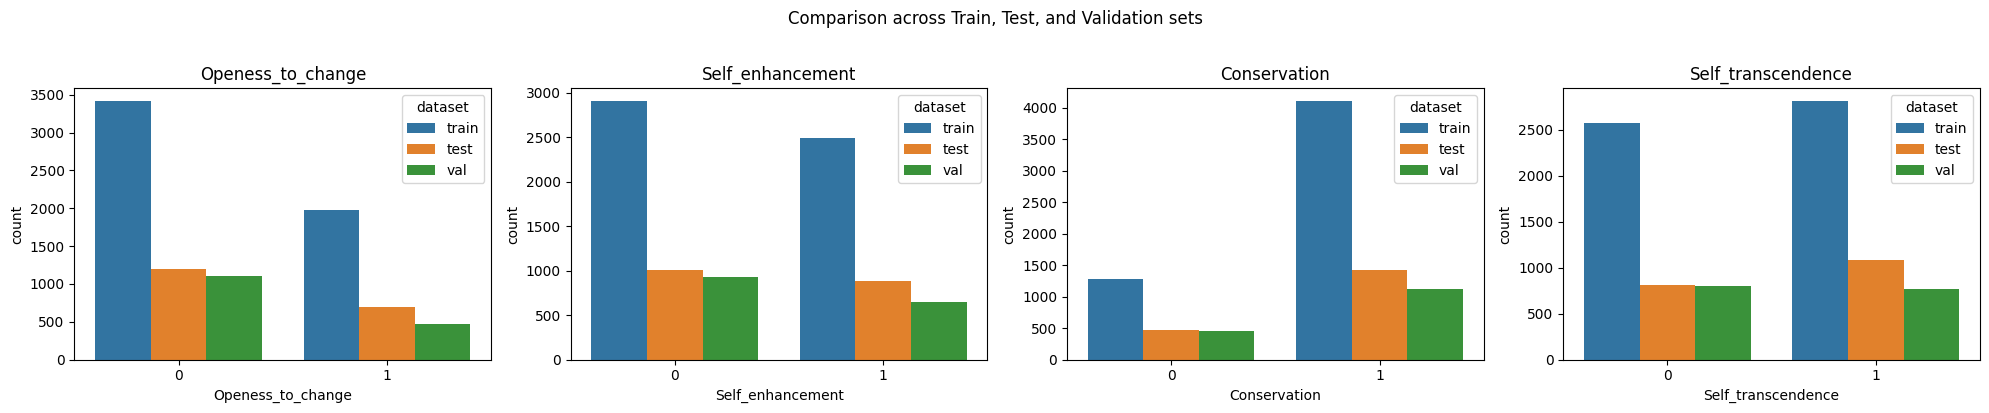

In [9]:
plot_comparison_across_sets(train_labels_df, val_labels_df, test_labels_df)


## Task 2 & Task 3 & task 4

### Creating the directory to store the results for our grid search


In [10]:
if not os.path.exists(RESULT_DIRECTORY):
    os.makedirs(RESULT_DIRECTORY)
    os.makedirs(os.path.join(RESULT_DIRECTORY, GRID_DIRECTORY))
    os.makedirs(os.path.join(RESULT_DIRECTORY, WEIGHTS_DIRECTORY))
    

### Models Definition

####  1) Random uniform classifier

In [11]:
if RUN_RANDOM_CLF:
    # Create an instance of the random uniform classifier
    random_classifier = RandomUniformClassifier(N_LABELS)
    
    # Make predictions on the test set
    predicted_labels = random_classifier.predict(test_arg_df)
    
    # F1 scores on the different labels singularly taken 
    f1_scorer = F1_Score_Multi_Labels(name='F1_binary', num_labels=N_LABELS, num_classes=N_CLASSES, mode='binary', compute_mean=False)
    f1_scores_random_classifier = f1_scorer(torch.tensor(test_labels_df.values.tolist()), torch.tensor(predicted_labels))
    # AVG F1 score
    f1_scorer.set_mode(compute_mean_flag=True)
    f1_avg_random_classifier =  f1_scorer(torch.tensor(test_labels_df.values.tolist()), torch.tensor(predicted_labels))
    
    
    for idx, f1_score in enumerate(f1_scores_random_classifier):
        print(f" - {train_labels_df.columns[idx]} F1: {f1_score}")
    
    print(f'\nAverage binary F1: {f1_avg_random_classifier}')


 - Openess_to_change F1: 0.403494837172359
 - Self_enhancement F1: 0.4322446143154969
 - Conservation F1: 0.608829568788501
 - Self_transcendence F1: 0.48465873512836566

Average binary F1: 0.4823069388511807


####  2) Majority classifier

In [12]:
if RUN_MAJORITY_CLF:
    majority_classifier = MajorityClassifier()
    
    # Train the majority classifier (even though in practice, no training is needed)
    majority_classifier.fit(train_labels_df)
    
    # Make predictions on the test set
    predicted_labels = majority_classifier.predict(test_labels_df)
    
    # F1 scores on the different labels singularly taken 
    f1_scorer = F1_Score_Multi_Labels(name='F1s_binary', num_labels=N_LABELS, num_classes=N_CLASSES, mode='binary', compute_mean=False)
    f1_scores_majority_classifier = f1_scorer(torch.tensor(test_labels_df.values.tolist()), torch.tensor(predicted_labels))
    # AVG F1 score
    f1_scorer.set_mode(compute_mean_flag=True)
    f1_avg_majority_classifier = f1_scorer(torch.tensor(test_labels_df.values.tolist()), torch.tensor(predicted_labels))
    
    
    for idx, f1_score in enumerate(f1_scores_majority_classifier):
        print(f" - {train_labels_df.columns[idx]} F1: {f1_score}")
    
    print(f'\nAverage binary F1: {f1_avg_majority_classifier}')


 - Openess_to_change F1: 0.0
 - Self_enhancement F1: 0.0
 - Conservation F1: 0.8304267161410018
 - Self_transcendence F1: 0.6570089475926715

Average binary F1: 0.37185891593341835


####  3) Bert w/C

##### Searching the hyperparameters for bert w/C
Here, a grid search is performed to find the best combination of hyperparameters for the baseline model. In order to select the 6 possible sets of hyperparameters tested during the search, we manually annotated the F1 obtained with promising configurations, then we kept the 6 most well-performing for the grid-search. At the end of the computation, all the relevant information are stored locally, ready to be analyzed and compared to the other models.

In [13]:
if RUN_BERTONE_GRID_SEARCH:
    hyperparameters_key_to_save = ['optimizer', 'pretrained_model_name_or_path', 'dropout_prob']
    seeds = [69, 42, 21]
    
    criterion = Criterion('loss', loss_function=torch.nn.BCELoss(reduction='none'), reduction_function=torch.mean)
    optimizers = [OptimizerWrapper(torch.optim.Adam, identifier=f'lr={10**(-5)}', optimizer_partial_params={'lr':10**(-5)})]
    metrics = [[F1_Score_Multi_Labels(name='F1_binary_avg', num_labels=N_LABELS, num_classes=N_CLASSES, mode='binary', compute_mean=True)]] 
    early_stopper = EarlyStopper(monitor='F1_binary_avg', patience=PATIENCE, delta=0, mode='max', restore_weights=True)
    
                        
    model_hyperparameters_to_test = [{'model_class': BertOne,
                                      'dropout_prob': i,
                                      'hidden_size': 768,
                                      'pretrained_model_name_or_path': os.path.join(BERT_MODELS_DIRECTORY, version),
                                      'bert_constructor': BERT_CONSTRUCTORS[version],
                                     } for i in [0, 0.3, 0.5] for version in BERT_VERSIONS]
    
    training_hyperparameters_to_test = [{'num_epochs': 20,
                                         'optimizer': opt,
                                         'batch_size': BATCH_SIZE_C,
                                         'criterion': criterion,
                                         'metrics': metrics[0],
                                         'early_stopper': early_stopper,
                                         } for opt in optimizers]
    
    
    partial_build_dataloader = partial(build_dataloader, 
                                       model_input=MODEL_INPUTS['C'],
                                       custom_dataset_builder=MODEL_DATASET_BUILDERS['C'],
                                       batch_size=MODEL_BATCH_SIZES['C'])  
    

    grid_search_train_validation(train_data=(train_arg_df, train_labels_df),
                                 val_data=(val_arg_df, val_labels_df),
                                 dataloader_builder=partial_build_dataloader,
                                 dataloader_parameters_unpacking_strategy=unpacking_dataloader_builder_parameters_strategy,
                                 variable_dataloader_parameters=['pretrained_model_name_or_path', 'batch_size'],
                                 shuffle=True,
                                 model_hyperparameters_to_test=model_hyperparameters_to_test,
                                 training_hyperparameters_to_test=training_hyperparameters_to_test,
                                 hyperparameters_key_to_save=hyperparameters_key_to_save,
                                 seeds=seeds,
                                 device=device,
                                 path_to_grid_search_results=BERTONE_GRID_SEARCH_RESULTS_PATH) 
                                 

100%|██████████| 6/6 [1:23:33<00:00, 835.56s/it]


##### Grid search results for bert w/C

In [14]:
BertOne_grid_search_results_df = joblib.load(BERTONE_GRID_SEARCH_RESULTS_PATH)
BertOne_grid_search_results_df = BertOne_grid_search_results_df.sort_values(by='F1_binary_avg_val_mean', ascending=False)

BertOne_grid_search_results_df


,optimizer,pretrained_model_name_or_path,dropout_prob,mean_time,std_time,F1_binary_avg_train_mean,F1_binary_avg_train_std,F1_binary_avg_val_mean,F1_binary_avg_val_std
3,Adam lr=1e-05,bert_models/roberta-base,0.3,201.166,59.966,0.672728,0.015969,0.625360,0.016843
1,Adam lr=1e-05,bert_models/roberta-base,0.0,234.807,53.878,0.674993,0.011655,0.621159,0.011571
0,Adam lr=1e-05,bert_models/bert-base-uncased,0.0,309.487,55.601,0.685152,0.002012,0.620783,0.008462
5,Adam lr=1e-05,bert_models/roberta-base,0.5,269.007,15.564,0.683411,0.005491,0.609767,0.022671
4,Adam lr=1e-05,bert_models/bert-base-uncased,0.5,317.268,44.090,0.684183,0.003090,0.609735,0.022315
2,Adam lr=1e-05,bert_models/bert-base-uncased,0.3,337.055,74.489,0.691815,0.007612,0.593466,0.004926


#### 4) Bert w/CP

##### Searching the hyperparameters for bert w/CP
A grid search is performed also for Bert w/CP, on 6 sets of possible hyperparameter configurations.


In [15]:
if RUN_BERTWO_GRID_SEARCH:
    hyperparameters_key_to_save = ['optimizer', 'pretrained_model_name_or_path', 'dropout_prob']
    seeds = [69, 42, 21]
    
    criterion = Criterion(name='BCELoss', loss_function=torch.nn.BCELoss(reduction='none'), reduction_function=torch.mean)
    optimizers = [OptimizerWrapper(torch.optim.Adam, identifier=f'lr={10**(-5)}', optimizer_partial_params={'lr':10 ** (-5)})]
    metrics = [[F1_Score_Multi_Labels(name='F1_binary_avg', num_labels=N_LABELS, num_classes=N_CLASSES, mode='binary', compute_mean=True)]] 
    early_stopper = EarlyStopper(monitor='F1_binary_avg', patience=PATIENCE, delta=0, mode='max', restore_weights=True)
    

    model_hyperparameters_to_test = [{'model_class': BerTwo,
                                      'dropout_prob': i,
                                      'hidden_size': 768,
                                      'pretrained_model_name_or_path': os.path.join(BERT_MODELS_DIRECTORY, version),
                                      'bert_constructor': BERT_CONSTRUCTORS[version],
                                     } for i in [0, 0.3, 0.5] for version in BERT_VERSIONS]
    
    training_hyperparameters_to_test = [{'num_epochs': 20,
                                         'optimizer': opt,
                                         'batch_size': BATCH_SIZE_CP,
                                         'criterion': criterion,
                                         'metrics': metrics[0],
                                         'early_stopper': early_stopper,
                                         } for opt in optimizers]
    
    
    partial_build_dataloader = partial(build_dataloader, 
                                       model_input=MODEL_INPUTS['CP'],
                                       custom_dataset_builder=MODEL_DATASET_BUILDERS['CP'],
                                       batch_size=MODEL_BATCH_SIZES['CP'])  
   

    grid_search_train_validation(train_data=(train_arg_df, train_labels_df),
                                 val_data=(val_arg_df, val_labels_df),
                                 dataloader_builder=partial_build_dataloader,
                                 dataloader_parameters_unpacking_strategy=unpacking_dataloader_builder_parameters_strategy,
                                 variable_dataloader_parameters=['pretrained_model_name_or_path', 'batch_size'],
                                 shuffle=True,
                                 model_hyperparameters_to_test=model_hyperparameters_to_test,
                                 training_hyperparameters_to_test=training_hyperparameters_to_test,
                                 hyperparameters_key_to_save=hyperparameters_key_to_save,
                                 seeds=seeds,
                                 device=device,
                                 path_to_grid_search_results=BERTWO_GRID_SEARCH_RESULTS_PATH) 
                                 

100%|██████████| 6/6 [5:05:50<00:00, 3058.48s/it]  


##### Grid search results for bert w/CP


In [16]:
BerTwo_grid_search_results_df = joblib.load(BERTWO_GRID_SEARCH_RESULTS_PATH)
BerTwo_grid_search_results_df = BerTwo_grid_search_results_df.sort_values(by='F1_binary_avg_val_mean', ascending=False)
BerTwo_grid_search_results_df


,optimizer,pretrained_model_name_or_path,dropout_prob,mean_time,std_time,F1_binary_avg_train_mean,F1_binary_avg_train_std,F1_binary_avg_val_mean,F1_binary_avg_val_std
3,Adam lr=1e-05,bert_models/roberta-base,0.3,766.773,5.040,0.792315,0.002462,0.720717,0.004677
1,Adam lr=1e-05,bert_models/roberta-base,0.0,769.910,5.083,0.797745,0.004492,0.718351,0.005423
5,Adam lr=1e-05,bert_models/roberta-base,0.5,772.979,4.679,0.784950,0.003638,0.716115,0.004387
2,Adam lr=1e-05,bert_models/bert-base-uncased,0.3,1328.113,377.171,0.884763,0.080555,0.714331,0.002246
0,Adam lr=1e-05,bert_models/bert-base-uncased,0.0,1160.318,268.872,0.868019,0.059894,0.712278,0.003410
4,Adam lr=1e-05,bert_models/bert-base-uncased,0.5,1313.936,455.809,0.867215,0.086399,0.708348,0.005139


#### 5) Bert w/CPS

##### Searching the hyperparameters for bert w/C
A grid search is performed also for Bert w/CPS, on 6 sets of possible hyperparameter configurations.


In [17]:
if RUN_BERTHREE_GRID_SEARCH:
    hyperparameters_key_to_save = ['optimizer', 'pretrained_model_name_or_path', 'dropout_prob']
    seeds = [69, 42, 21]
    
    criterion = Criterion(name='BCELoss', loss_function=torch.nn.BCELoss(reduction='none'), reduction_function=torch.mean)
    optimizers = [OptimizerWrapper(torch.optim.Adam, identifier=f'lr={10**(-5)}', optimizer_partial_params={'lr':10 ** (-5)})]
    metrics = [[F1_Score_Multi_Labels(name='F1_binary_avg', num_labels=N_LABELS, num_classes=N_CLASSES, mode='binary', compute_mean=True)]] 
    early_stopper = EarlyStopper(monitor='F1_binary_avg', patience=PATIENCE, delta=0, mode='max', restore_weights=True)
    

    model_hyperparameters_to_test = [{'model_class': BerThree,
                                      'dropout_prob': i,
                                      'hidden_size': 768,
                                      'pretrained_model_name_or_path': os.path.join(BERT_MODELS_DIRECTORY, version),
                                      'bert_constructor': BERT_CONSTRUCTORS[version],
                                     } for i in [0, 0.3, 0.5] for version in BERT_VERSIONS]
    
    training_hyperparameters_to_test = [{'num_epochs': 20,
                                         'optimizer': opt,
                                         'batch_size': BATCH_SIZE_CPS,
                                         'criterion': criterion,
                                         'metrics': metrics[0],
                                         'early_stopper': early_stopper,
                                         } for opt in optimizers]
    
    
    partial_build_dataloader = partial(build_dataloader, 
                                       model_input=MODEL_INPUTS['CPS'],
                                       custom_dataset_builder=MODEL_DATASET_BUILDERS['CPS'],
                                       batch_size=MODEL_BATCH_SIZES['CPS'])  
    

    grid_search_train_validation(train_data=(train_arg_df, train_labels_df),
                                 val_data=(val_arg_df, val_labels_df),
                                 dataloader_builder=partial_build_dataloader,
                                 dataloader_parameters_unpacking_strategy=unpacking_dataloader_builder_parameters_strategy,
                                 variable_dataloader_parameters=['pretrained_model_name_or_path', 'batch_size'],
                                 shuffle=True,
                                 model_hyperparameters_to_test=model_hyperparameters_to_test,
                                 training_hyperparameters_to_test=training_hyperparameters_to_test,
                                 hyperparameters_key_to_save=hyperparameters_key_to_save,
                                 seeds=seeds,
                                 device=device,
                                 path_to_grid_search_results=BERTHREE_GRID_SEARCH_RESULTS_PATH) 
                                 

100%|██████████| 6/6 [5:58:11<00:00, 3581.96s/it]  


##### Grid search results for bert w/C


In [18]:
BerThree_grid_search_results_df = joblib.load(BERTHREE_GRID_SEARCH_RESULTS_PATH)
BerThree_grid_search_results_df = BerThree_grid_search_results_df.sort_values(by='F1_binary_avg_val_mean', ascending=False)
BerThree_grid_search_results_df


,optimizer,pretrained_model_name_or_path,dropout_prob,mean_time,std_time,F1_binary_avg_train_mean,F1_binary_avg_train_std,F1_binary_avg_val_mean,F1_binary_avg_val_std
3,Adam lr=1e-05,bert_models/roberta-base,0.3,1162.141,378.353,0.873821,0.072750,0.723675,0.006460
1,Adam lr=1e-05,bert_models/roberta-base,0.0,961.285,143.011,0.843685,0.031657,0.723218,0.003942
5,Adam lr=1e-05,bert_models/roberta-base,0.5,959.451,143.088,0.825771,0.028081,0.721933,0.002319
2,Adam lr=1e-05,bert_models/bert-base-uncased,0.3,1506.093,320.056,0.927814,0.048434,0.711668,0.000815
0,Adam lr=1e-05,bert_models/bert-base-uncased,0.0,1273.400,228.449,0.895958,0.043457,0.711488,0.004539
4,Adam lr=1e-05,bert_models/bert-base-uncased,0.5,1297.146,446.133,0.867221,0.090572,0.704366,0.007284


#### Extracting the best hyperparameters for our models

In [19]:
best_hyperparameters_bertOne = BertOne_grid_search_results_df.iloc[0].copy()
best_hyperparameters_berTwo = BerTwo_grid_search_results_df.iloc[0].copy()
best_hyperparameters_berThree = BerThree_grid_search_results_df.iloc[0].copy()

best_hyperparameters_bertOne['source'] = 'bert w/C'
best_hyperparameters_berTwo['source'] = 'bert w/CP'
best_hyperparameters_berThree['source'] = 'bert w/CPS'

best_hyperparameters_df = pd.concat([best_hyperparameters_bertOne, best_hyperparameters_berTwo, best_hyperparameters_berThree], 
                                    ignore_index=True, 
                                    axis=1).T

best_hyperparameters_df.set_index('source', inplace=True)

best_hyperparameters_df


,optimizer,pretrained_model_name_or_path,dropout_prob,mean_time,std_time,F1_binary_avg_train_mean,F1_binary_avg_train_std,F1_binary_avg_val_mean,F1_binary_avg_val_std
source,,,,,,,,,
bert w/C,Adam lr=1e-05,bert_models/roberta-base,0.3,201.166,59.966,0.672728,0.015969,0.62536,0.016843
bert w/CP,Adam lr=1e-05,bert_models/roberta-base,0.3,766.773,5.04,0.792315,0.002462,0.720717,0.004677
bert w/CPS,Adam lr=1e-05,bert_models/roberta-base,0.3,1162.141,378.353,0.873821,0.07275,0.723675,0.00646


#### Creating Data loaders
Here, we create the data loaders for the individual training phase of each model

In [20]:
dataloaders = {}

for model_path in bert_versions_paths:
    model_name = os.path.basename(model_path)
    dataloaders[model_name] = {}
    
    for model_key in MODEL_INPUTS.keys():
        dataloaders[model_name][model_key] = {}
     
        dataloader_train = build_dataloader(data=train_arg_df, 
                                            labels=train_labels_df, 
                                            pretrained_model_name_or_path=model_path, 
                                            tokenizer_constructor=BERT_TOKENIZER_CONSTRUCTORS[model_name],
                                            model_input=MODEL_INPUTS[model_key],
                                            custom_dataset_builder=MODEL_DATASET_BUILDERS[model_key],
                                            batch_size=MODEL_BATCH_SIZES[model_key], 
                                            shuffle=True)  
    
        dataloader_val = build_dataloader(data=val_arg_df, 
                                          labels=val_labels_df, 
                                          pretrained_model_name_or_path=model_path, 
                                          tokenizer_constructor=BERT_TOKENIZER_CONSTRUCTORS[model_name],
                                          model_input=MODEL_INPUTS[model_key],
                                          custom_dataset_builder=MODEL_DATASET_BUILDERS[model_key],
                                          batch_size=MODEL_BATCH_SIZES[model_key], 
                                          shuffle=True)  
  
        dataloader_test = build_dataloader(data=test_arg_df, 
                                           labels=test_labels_df,
                                           pretrained_model_name_or_path=model_path, 
                                           tokenizer_constructor=BERT_TOKENIZER_CONSTRUCTORS[model_name],
                                           model_input=MODEL_INPUTS[model_key],
                                           custom_dataset_builder=MODEL_DATASET_BUILDERS[model_key],
                                           batch_size=MODEL_BATCH_SIZES[model_key], 
                                           shuffle=False)  
       

        dataloaders[model_name][model_key]['train'] = dataloader_train
        dataloaders[model_name][model_key]['val'] = dataloader_val
        dataloaders[model_name][model_key]['test'] = dataloader_test


### Training Bert based models

1)  Training bert w/C

In [21]:
torch.manual_seed(42)
np.random.seed(42)


bert1 = BertOne(dropout_prob=0.3, 
                hidden_size= 768, 
                pretrained_model_name_or_path='bert_models/roberta-base',
                bert_constructor=transformers.RobertaModel).to(device)


if FIT_BERTONE:
    optimizer_test = OptimizerWrapper(torch.optim.Adam, identifier=f'lr={1e-5}', optimizer_partial_params={'lr': 1e-5})       
    criterion_test = Criterion(name='BCELoss', loss_function=torch.nn.BCELoss(reduction='none'), reduction_function=torch.mean)
    
    
    bert1_history = bert1.fit(train_loader=dataloaders['roberta-base']['C']['train'],
                              val_loader=dataloaders['roberta-base']['C']['val'],
                              criterion=criterion_test,
                              metrics=[F1_Score_Multi_Labels(name='F1_binary_avg', num_labels=N_LABELS, num_classes=N_CLASSES, mode='binary', compute_mean=True)],
                              optimizer=optimizer_test,
                              early_stopper=EarlyStopper(monitor='F1_binary_avg', patience=PATIENCE, delta=0, mode='max', restore_weights=True),
                              num_epochs=20)
    
    torch.save(bert1.state_dict(), BERTONE_WEIGHTS_PATH)

else:
    bert1.load_state_dict(torch.load(BERTONE_WEIGHTS_PATH))
    bert1_history = None
    

 Epoch: 1/20 Iterations: 169/169 Time: 32.346s - BCELoss: 0.600327134132385 - F1_binary_avg: 0.562732928046781 - val_BCELoss: 0.642338335514069 - val_F1_binary_avg: 0.456686191247779 
 Epoch: 2/20 Iterations: 169/169 Time: 32.446s - BCELoss: 0.574794828891754 - F1_binary_avg: 0.650106781378986 - val_BCELoss: 0.627391159534454 - val_F1_binary_avg: 0.608501093183603 
 Epoch: 3/20 Iterations: 169/169 Time: 32.463s - BCELoss: 0.568188309669495 - F1_binary_avg: 0.67090860040819 - val_BCELoss: 0.627651154994965 - val_F1_binary_avg: 0.624720626700954 
 Epoch: 4/20 Iterations: 169/169 Time: 32.38s - BCELoss: 0.56699812412262 - F1_binary_avg: 0.661479636180214 - val_BCELoss: 0.630265712738037 - val_F1_binary_avg: 0.61949236503795 
 Epoch: 5/20 Iterations: 169/169 Time: 32.368s - BCELoss: 0.563395857810974 - F1_binary_avg: 0.677750931628454 - val_BCELoss: 0.629835069179535 - val_F1_binary_avg: 0.608546092774482 
 Epoch: 6/20 Iterations: 169/169 Time: 32.369s - BCELoss: 0.55995911359787 - F1_bina

###### Plotting the training and validation history for our bert w/C

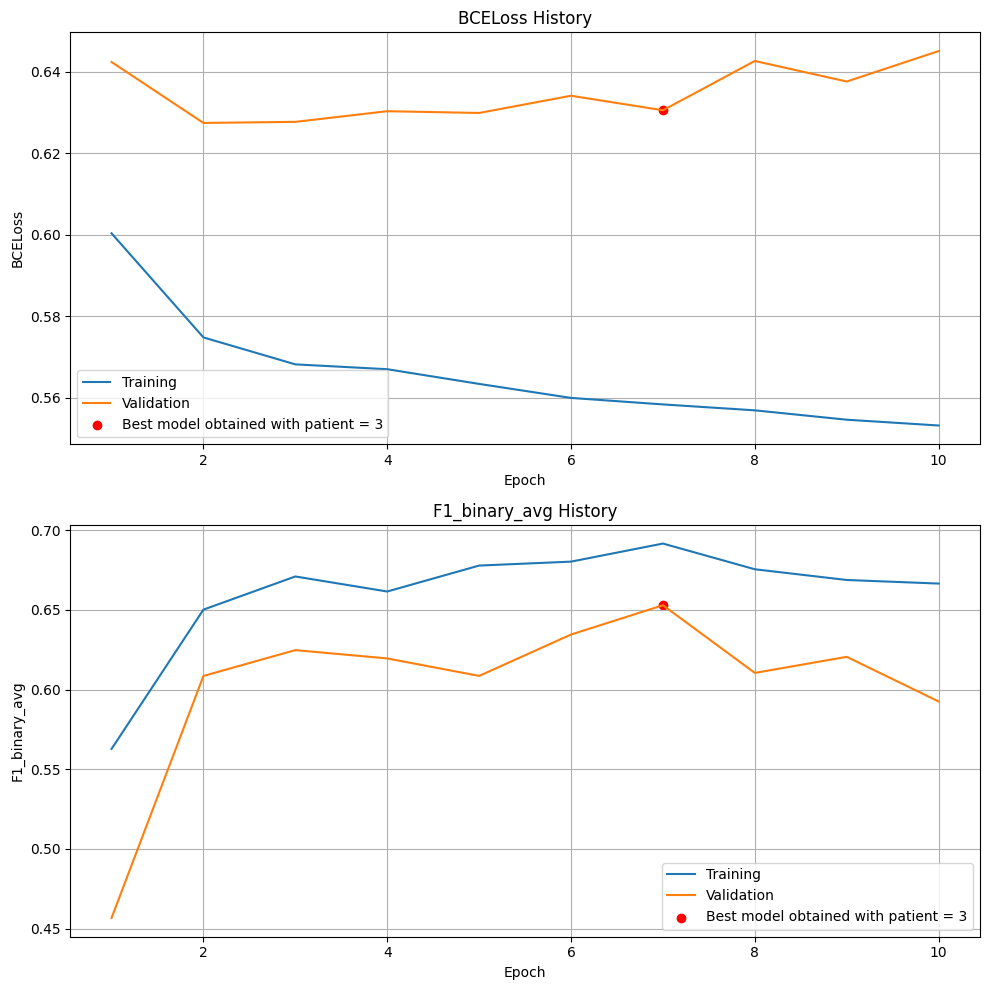

In [22]:
if FIT_BERTONE:
    plot_history(bert1_history, patience=PATIENCE)

else:
    print("To show the bert w/C training history you should set the flag FIT_BERTONE=True ")


######  2) Fitting bert w/CP


In [23]:
torch.manual_seed(42)
np.random.seed(42)


bert2 = BerTwo(dropout_prob=0.3, 
               hidden_size= 768,
               pretrained_model_name_or_path='bert_models/roberta-base',   
               bert_constructor=transformers.RobertaModel).to(device)


if FIT_BERTWO:
    optimizer_test = OptimizerWrapper(torch.optim.Adam, identifier=f'lr={1e-5}', optimizer_partial_params={'lr': 1e-5})          
   
    criterion_test = Criterion(name='BCELoss', loss_function=torch.nn.BCELoss(reduction='none'), reduction_function=torch.mean)
    
    
    bert2_history = bert2.fit(train_loader=dataloaders['roberta-base']['CP']['train'], 
                              val_loader=dataloaders['roberta-base']['CP']['val'], 
                              criterion=criterion_test, 
                              metrics=[F1_Score_Multi_Labels(name='F1_binary_avg', num_labels=N_LABELS, num_classes=N_CLASSES, mode='binary', compute_mean=True)],
                              optimizer=optimizer_test,
                              early_stopper=EarlyStopper(monitor='F1_binary_avg', patience=PATIENCE, delta=0, mode='max', restore_weights=True),
                              num_epochs=20)
    
    torch.save(bert2.state_dict(), BERTWO_WEIGHTS_PATH)

else:
    bert2.load_state_dict(torch.load(BERTWO_WEIGHTS_PATH))
    bert2_history = None
    

 Epoch: 1/20 Iterations: 338/338 Time: 155.785s - BCELoss: 0.502450108528137 - F1_binary_avg: 0.734200137578422 - val_BCELoss: 0.572250068187714 - val_F1_binary_avg: 0.675502789967287 
 Epoch: 2/20 Iterations: 338/338 Time: 155.698s - BCELoss: 0.445876926183701 - F1_binary_avg: 0.78479157064303 - val_BCELoss: 0.546688139438629 - val_F1_binary_avg: 0.709987255830412 
 Epoch: 3/20 Iterations: 338/338 Time: 155.764s - BCELoss: 0.397539675235748 - F1_binary_avg: 0.815234385518002 - val_BCELoss: 0.550287306308746 - val_F1_binary_avg: 0.703590686387147 
 Epoch: 4/20 Iterations: 338/338 Time: 155.392s - BCELoss: 0.34360072016716 - F1_binary_avg: 0.856740962183134 - val_BCELoss: 0.563647329807282 - val_F1_binary_avg: 0.720333161752637 
 Epoch: 5/20 Iterations: 338/338 Time: 155.461s - BCELoss: 0.275783807039261 - F1_binary_avg: 0.893352845687845 - val_BCELoss: 0.589340150356293 - val_F1_binary_avg: 0.71158344173626 
 Epoch: 6/20 Iterations: 338/338 Time: 155.452s - BCELoss: 0.224164307117462 -

###### Plotting the training and validation history for our bert w/C

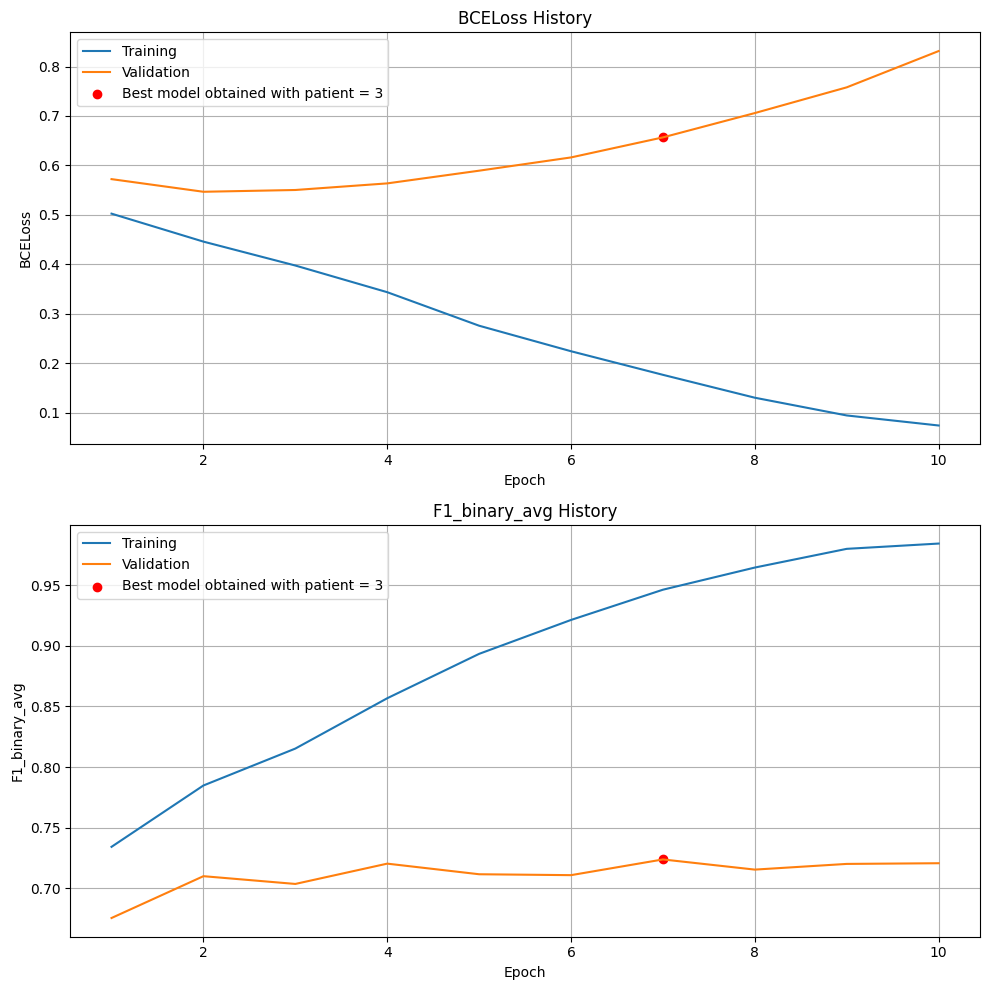

In [24]:
if FIT_BERTWO:
    plot_history(bert2_history, patience=PATIENCE)
else:
    print("To show the bert w/CP training history you should set the flag FIT_BERTWO=True")
    

######  3) Fitting bert w/CPS


In [25]:
torch.manual_seed(42)
np.random.seed(42)


bert3 = BerThree(dropout_prob=0.3, 
                 hidden_size= 768, 
                 pretrained_model_name_or_path='bert_models/roberta-base', 
                 bert_constructor=transformers.RobertaModel).to(device)                                                          


if FIT_BERTHREE:
    optimizer_test = OptimizerWrapper(torch.optim.Adam, identifier=f'lr={1e-5}', optimizer_partial_params={'lr': 1e-5})          
    
    criterion_test = Criterion(name='BCELoss', loss_function=torch.nn.BCELoss(reduction='none'), reduction_function=torch.mean)
    
    
    bert3_history = bert3.fit(train_loader=dataloaders['roberta-base']['CPS']['train'], 
                              val_loader=dataloaders['roberta-base']['CPS']['val'], 
                              criterion=criterion_test, 
                              metrics=[F1_Score_Multi_Labels(name='F1_binary_avg', num_labels=N_LABELS, num_classes=N_CLASSES, mode='binary', compute_mean=True)],
                              optimizer=optimizer_test,
                              early_stopper=EarlyStopper(monitor='F1_binary_avg', patience=PATIENCE, delta=0, mode='max', restore_weights=True),
                              num_epochs=20)
    
    torch.save(bert3.state_dict(), BERTHREE_WEIGHTS_PATH)

else:
    bert3.load_state_dict(torch.load(BERTHREE_WEIGHTS_PATH))
    bert3_history = None
    

 Epoch: 1/20 Iterations: 338/338 Time: 155.694s - BCELoss: 0.497615873813629 - F1_binary_avg: 0.735450603868346 - val_BCELoss: 0.567369818687439 - val_F1_binary_avg: 0.679989412639166 
 Epoch: 2/20 Iterations: 338/338 Time: 156.449s - BCELoss: 0.451179206371307 - F1_binary_avg: 0.77505727865448 - val_BCELoss: 0.559210360050201 - val_F1_binary_avg: 0.705256304901113 
 Epoch: 3/20 Iterations: 338/338 Time: 156.626s - BCELoss: 0.38270503282547 - F1_binary_avg: 0.828799939831225 - val_BCELoss: 0.553622603416443 - val_F1_binary_avg: 0.716692915222128 
 Epoch: 4/20 Iterations: 338/338 Time: 156.053s - BCELoss: 0.342018812894821 - F1_binary_avg: 0.85866741706433 - val_BCELoss: 0.577477812767029 - val_F1_binary_avg: 0.721565766481072 
 Epoch: 5/20 Iterations: 338/338 Time: 154.818s - BCELoss: 0.277155756950378 - F1_binary_avg: 0.897445761226303 - val_BCELoss: 0.600956439971924 - val_F1_binary_avg: 0.717996704722859 
 Epoch: 6/20 Iterations: 338/338 Time: 154.852s - BCELoss: 0.214777678251266 -

##### Plotting the training and validation history for our bert w/CPS


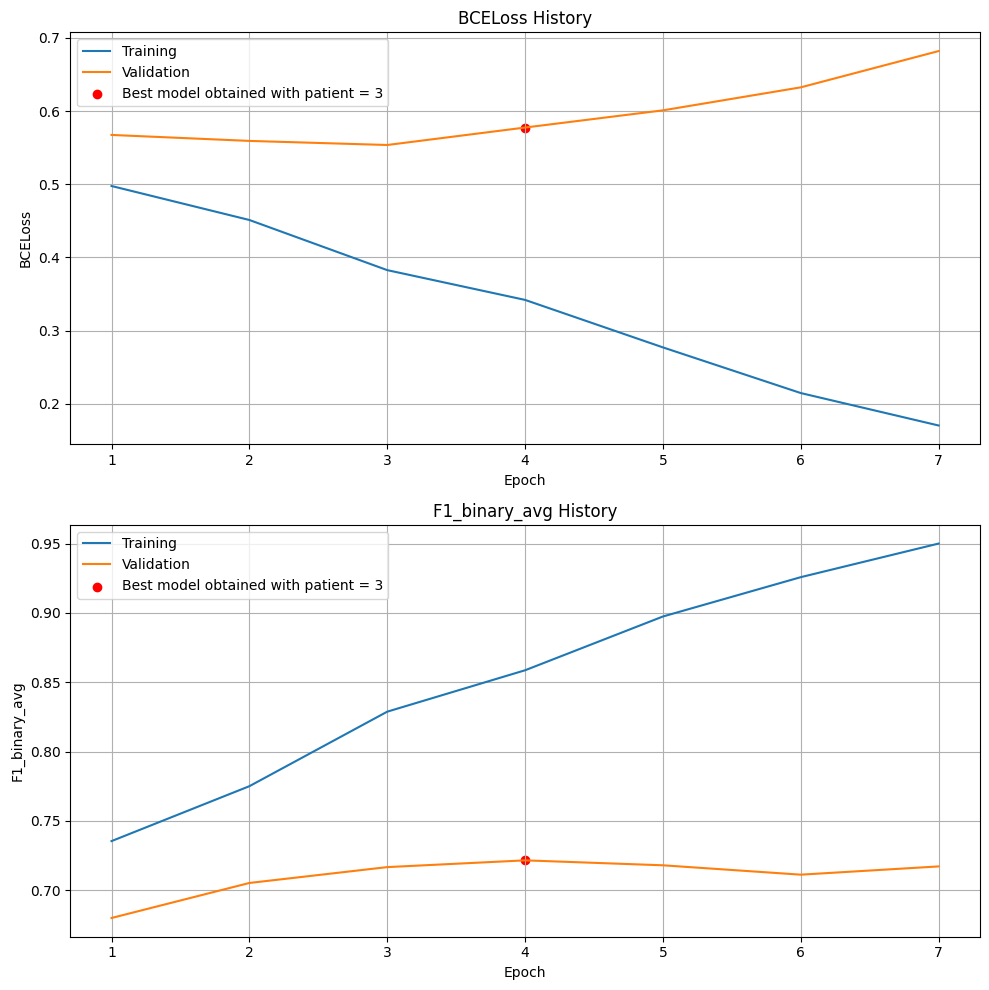

In [26]:
if FIT_BERTHREE:
    plot_history(bert3_history, patience=PATIENCE)
else:
    print("To show the bert w/CPS training history you should set the flag FIT_BERTHREE=True")
    

### Calculating the metrics of our models on the test set

In [27]:
f1_scorer = F1_Score_Multi_Labels(name='F1_binary_avg', num_labels=N_LABELS, num_classes=N_CLASSES, mode='binary',compute_mean=False)

bert_1_predicted_labels = bert1.predict(dataloaders['roberta-base']['C']['test'])   
bert_2_predicted_labels = bert2.predict(dataloaders['roberta-base']['CP']['test'])     
bert_3_predicted_labels = bert3.predict(dataloaders['roberta-base']['CPS']['test'])

#F1 scores for each class
f1_scores_bert_1 = f1_scorer(torch.tensor(test_labels_df.values), bert_1_predicted_labels)
f1_scores_bert_2 = f1_scorer(torch.tensor(test_labels_df.values), bert_2_predicted_labels)
f1_scores_bert_3 = f1_scorer(torch.tensor(test_labels_df.values), bert_3_predicted_labels)

# AVG F1 scores
f1_scorer.set_mode(compute_mean_flag=True)
f1_avg_bert_1 = f1_scorer(torch.tensor(test_labels_df.values), bert_1_predicted_labels)
f1_avg_bert_2 = f1_scorer(torch.tensor(test_labels_df.values), bert_2_predicted_labels)
f1_avg_bert_3 = f1_scorer(torch.tensor(test_labels_df.values), bert_3_predicted_labels)


### Visualizing the F1 macro scores for each model  

In [28]:
models = ['bert w/C', 'bert w/CP', 'bert w/CPS']
labels = train_labels_df.columns

data = [*zip(labels, f1_scores_bert_1, f1_scores_bert_2, f1_scores_bert_3),
        ['Avg', f1_avg_bert_1, f1_avg_bert_2, f1_avg_bert_3]
        ]

table = tabulate(data, headers=['Model'] + models, tablefmt='grid')
print(table)


+--------------------+------------+-------------+--------------+
| Model              |   bert w/C |   bert w/CP |   bert w/CPS |
+====================+============+=============+==============+
| Openess_to_change  |   0.445872 |    0.607296 |     0.63139  |
+--------------------+------------+-------------+--------------+
| Self_enhancement   |   0.391791 |    0.647365 |     0.619765 |
+--------------------+------------+-------------+--------------+
| Conservation       |   0.829178 |    0.826381 |     0.8304   |
+--------------------+------------+-------------+--------------+
| Self_transcendence |   0.608388 |    0.641782 |     0.645201 |
+--------------------+------------+-------------+--------------+
| Avg                |   0.568807 |    0.680706 |     0.681689 |
+--------------------+------------+-------------+--------------+


## Task 5: 

### Error Analysis

**Random Classifier**
This model seems to give a moderate performance with an average F1 score of around 0.48. It has the lowest performance in "Openness to Change" and the highest in "Conservation."

**Majority Classifier**
This classifier despite a higher accuracy, report an F1 score of $0.0$ in those classes where the label 0 is the most frequent. It's important to note that evaluating a model's performance in this way doesn't provide meaningful insights because the model is not making any correct positive predictions (True Positives). On the other hand, it obtains very good performance on those classes where the most common label is 1, with values of F1 up to 0.83 for Conservation and 0.65 for Self Transcendence. Because of this, the average value of F1 is 0.37.

**BERT-based models**
All three BERT-based models (BERT w/C, BERT w/CP, and BERT w/CPS) significantly outperform the baseline models in terms of average F1 scores:
- BERT w/C: Shows balanced performance across categories, with a notable improvement over the baseline models. This model is the worst one among the BERT-based ones, this is probably due to the fact that in the dataset there are several arguments with the same conclusion but different premise and stance. The fact that BERT w/C is trained using only the conclusion ignore this diversity between arguments with the same conclusion, leading to worse performances. 
- BERT w/CP: The inclusion of the premises demonstrates further improvement, especially in "Openness to Change" and "Self Enhancement", without noticeable enhancements in the F1 of the other classes.
- BERT w/CPS: This model shows the best overall performance, slightly improving upon BERT w/CP.

All BERT models show a substantial improvement. This suggests that these models have learned meaningful patterns in the data, as opposed to the random guessing strategy of the uniform classifier. Moreover, the incremental changes from BERT w/C to BERT w/CP and then to BERT w/CPS seem to provide marginal improvements. 


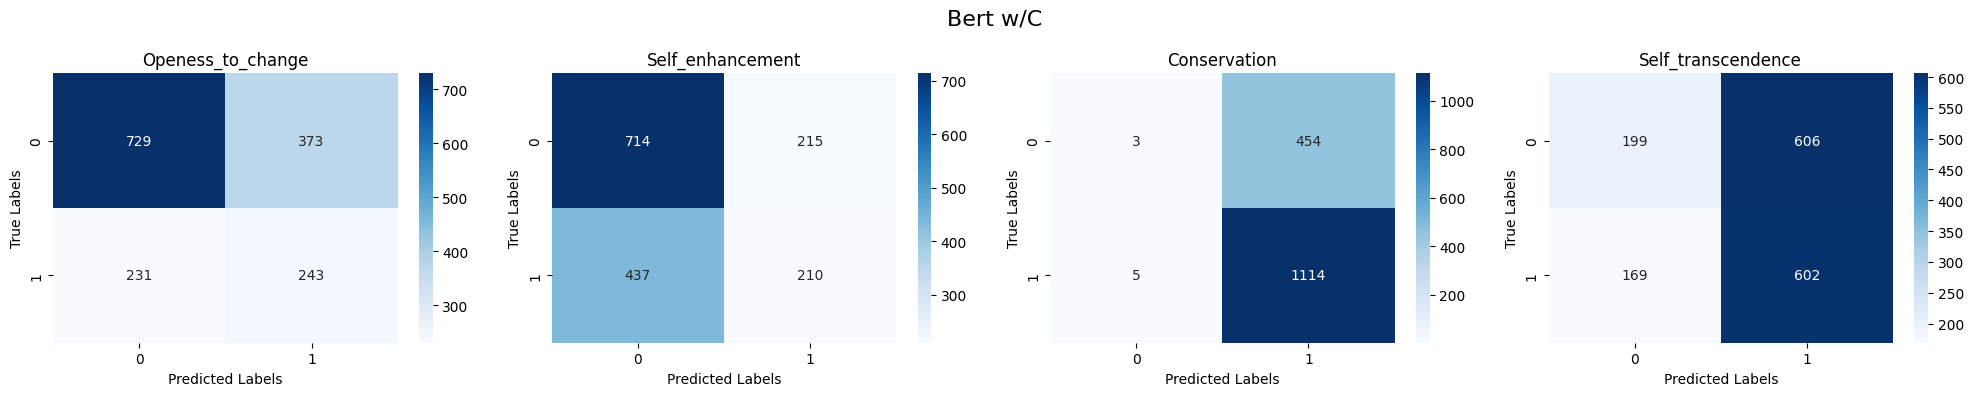

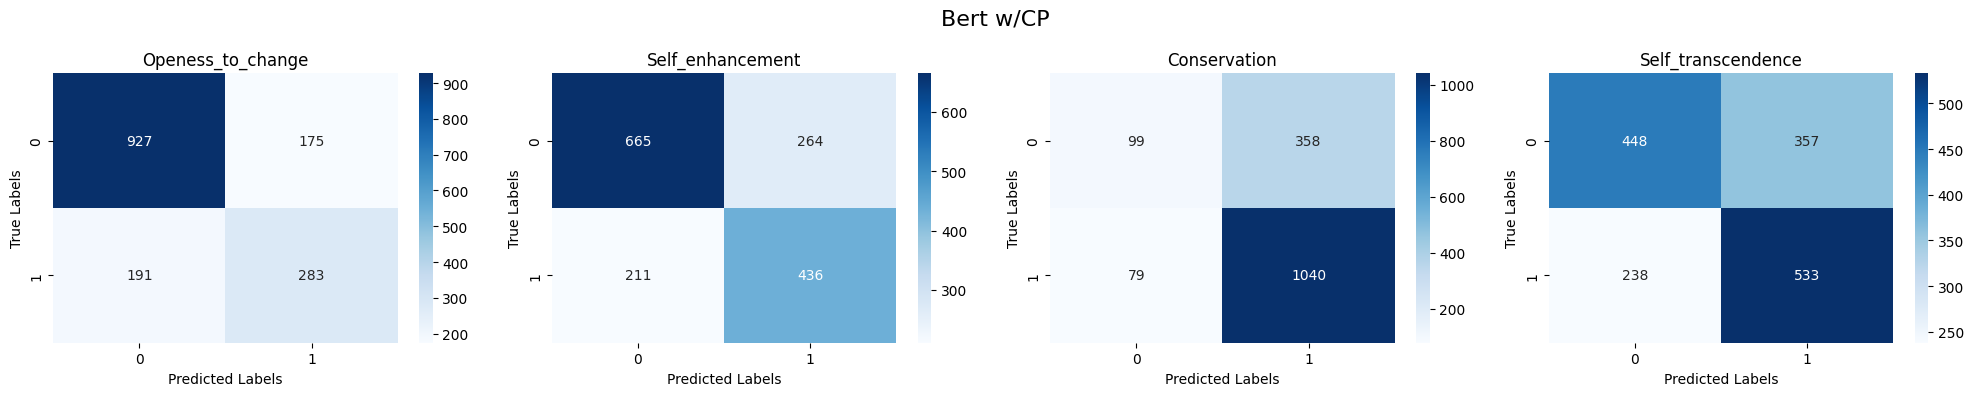

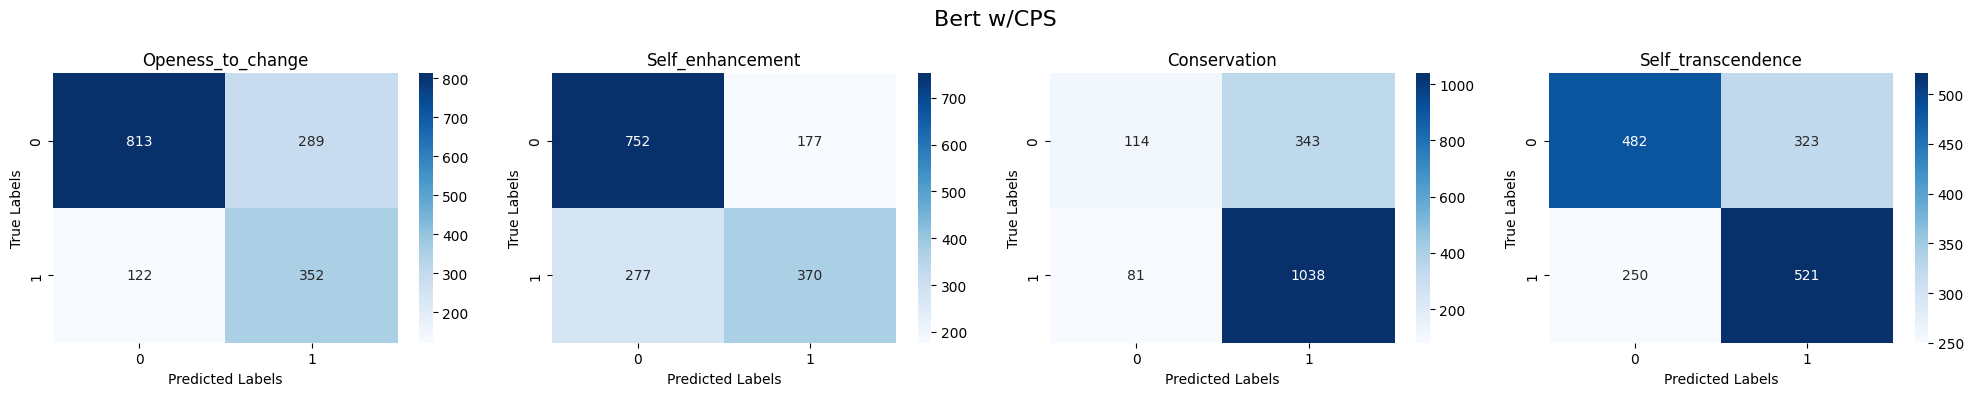

In [29]:
plot_confusion_matrices(bert_1_predicted_labels, torch.tensor(test_labels_df.values), title='Bert w/C')
plot_confusion_matrices(bert_2_predicted_labels, torch.tensor(test_labels_df.values), title='Bert w/CP')
plot_confusion_matrices(bert_3_predicted_labels, torch.tensor(test_labels_df.values), title='Bert w/CPS')
